In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
final_TSS_KO = pd.read_excel("Data_outputs/TSS_data_final/final_TSS_KO.xlsx")
final_TSS_WT = pd.read_excel("Data_outputs/TSS_data_final/final_TSS_WT.xlsx")

final_TTS_KO = pd.read_excel("Data_outputs/TTS_data_final/final_TTS_KO.xlsx")
final_TTS_WT = pd.read_excel("Data_outputs/TTS_data_final/final_TTS_WT.xlsx")

TSS_KO1 = pd.read_excel("Data_outputs/TSS_data/KO1_TSS_list.xlsx")
TSS_KO2 = pd.read_excel("Data_outputs/TSS_data/KO2_TSS_list.xlsx")
TSS_KO3 = pd.read_excel("Data_outputs/TSS_data/KO3_TSS_list.xlsx")
TSS_WT1 = pd.read_excel("Data_outputs/TSS_data/WT1_TSS_list.xlsx")
TSS_WT2 = pd.read_excel("Data_outputs/TSS_data/WT2_TSS_list.xlsx")
TSS_WT3 = pd.read_excel("Data_outputs/TSS_data/WT3_TSS_list.xlsx")

anot_file = pd.read_excel("Data_outputs/anot_file.xlsx")
raw_anot_file = pd.read_excel("Data_outputs/raw_anot_file.xlsx")
mbovis_cat = pd.read_csv("mbovis_categories.csv", sep = ",")
mbovis_cat.to_excel("mbovis_categories2.xlsx")

### TUs annotation
Transcriptional Unit (TU) -> genomic region that is transcribed into RNA as a single continuous unit.
    - Segment of the genome that contains one or more genes that are transcribed together under the control of the same regulatory elements, such as promoters

1. __Initial TU segmentation__: divide the genome into preliminary Trasncriptional Units (TUs). These preliminary TUs include genes that are transcribed in the same direction (check the gff file). If the distance between genes in the same preliminary TU is higher than 300, it will be further splitted. 
- __Step__: identify segments of the genome where genes are clustered together and transcribed in the same direction (either on the plus or minus strand).

In [3]:
## CODE FOR THE 1st STEP

def prel_TUs(anot_file): 

    TU_dict = {"TU_name":[], "TU_start":[], "TU_end":[], "TU_strand":[]}
    TU_number = 0

    start_positions = []
    for i in range(len(anot_file)-1):

        strand = anot_file.loc[i,"strand"]
        strand_next = anot_file.loc[i + 1,"strand"]
        gene_start = anot_file.loc[i,"start"]
        gene_end = anot_file.loc[i,"end"]
        next_gene_start = anot_file.loc[i + 1,"start"]
        
        # If the strand of the next CDS is the same and the distance between genes is less than 300 bp
        if strand == strand_next:
            start_positions.append(gene_start)
            
            # If the distance between the current gene and next gene is greater than 300 bp, split the TU
            if (next_gene_start - gene_end) > 300:
                TU_number += 1
                start_TU = min(start_positions)
                end_TU = gene_end
                start_positions.clear()  # Clears the list after splitting TU

                TU_dict["TU_name"].append(f"TU_{TU_number}")
                TU_dict["TU_start"].append(start_TU)
                TU_dict["TU_end"].append(end_TU)
                TU_dict["TU_strand"].append(strand)
                
            continue

        # Case when strands differ, create a new TU
        else:
            end_TU = anot_file.loc[i,"end"]
            start_TU = min(start_positions) if start_positions else anot_file.loc[i,"start"]
            start_positions.clear()  # Clears the list for the new TU

            TU_number += 1
            TU_dict["TU_name"].append(f"TU_{TU_number}")
            TU_dict["TU_start"].append(start_TU)
            TU_dict["TU_end"].append(end_TU)
            TU_dict["TU_strand"].append(strand)

    # For the last gene in the file (since it won't be processed in the loop)
    end_TU = anot_file.loc[len(anot_file)-1, "end"]
    start_TU = min(start_positions) if start_positions else anot_file.loc[len(anot_file)-1, "start"]
    TU_number += 1
    TU_dict["TU_name"].append(f"TU_{TU_number}")
    TU_dict["TU_start"].append(start_TU)
    TU_dict["TU_end"].append(end_TU)
    TU_dict["TU_strand"].append(anot_file.loc[len(anot_file)-1, "strand"])

    return pd.DataFrame(TU_dict)

preliminary_TUs = prel_TUs(anot_file)
preliminary_TUs.head(10)

,TU_name,TU_start,TU_end,TU_strand
0,TU_1,1,1524,+
1,TU_2,2052,11184,+
2,TU_3,11874,12311,-
3,TU_4,12468,13016,+
4,TU_5,13222,13994,-
5,TU_6,14088,15611,+
6,TU_7,15589,25425,-
7,TU_8,25625,25707,+
8,TU_9,25894,27423,-
9,TU_10,27576,33778,+


In [4]:
preliminary_TUs.iloc[790:810]

,TU_name,TU_start,TU_end,TU_strand
790,TU_791,2296145,2296480,+
791,TU_792,2296455,2301373,-
792,TU_793,2301449,2302162,+
793,TU_794,2302411,2303385,-
794,TU_795,2304603,2305033,+
795,TU_796,2305005,2309077,-
796,TU_797,2309155,2313025,+
797,TU_798,2312971,2315133,-
798,TU_799,2315268,2315825,+
799,TU_800,2315815,2320891,-


2. __Refining TUs Based on TSS Activity__ based on:

In [5]:
## CODE FOR THE 2nd STEP
# https://pmc.ncbi.nlm.nih.gov/articles/PMC1480536/ -> link for the paper that states the average distance between genes in an operon

def prel_TUs_proc(TSS_data, preliminary_TUs, anot_file):
    # Focus on the TSS that are no internal
    noint_TSS = TSS_data[(TSS_data["TSS_type"] == "Leader") | (TSS_data["TSS_type"] == "Leaderless") 
                        | (TSS_data["TSS_type"] == "Unknown")]


    TU_dict = {"TU_name": [], "TU_start": [], "TU_end": [], "TU_strand": []}
    TU_number = 0  # Initialize TU counter

    # Iterate over preliminary TUs
    for i in range(len(preliminary_TUs)):
        start_TU = preliminary_TUs.loc[i, "TU_start"]  
        end_TU = preliminary_TUs.loc[i, "TU_end"]    
        strand = preliminary_TUs.loc[i, "TU_strand"]  

        # Filter TSS positions within the current TU range and those located upstream the start of the TU. 
        TSS_within = noint_TSS[
            ((noint_TSS["TSS_position"] >= start_TU - 300) & (noint_TSS["TSS_position"] < start_TU)) |
            ((noint_TSS["TSS_position"] >= start_TU) & (noint_TSS["TSS_position"] <= end_TU))
        ]
        
        if TSS_within.empty:
            # Skip this TU if no TSS is found
            continue
        else:
            # Split TU based on TSS positions
            sorted_TSS = sorted(TSS_within["TSS_position"])

            if sorted_TSS[0] < start_TU:  # TSS upstream the TU start, TU start = TSS
                start_TU = sorted_TSS.pop(0)  # Removes the index from the ls, and the elements removed is assigned to start_TU   

            prev_start = start_TU # Initialize the start for splitting TUs

            for TSS_pos in sorted_TSS:
                # Collect gene names in the range
                TU_number += 1
                TU_dict["TU_name"].append(f"TU_{TU_number}")
                TU_dict["TU_start"].append(prev_start)
                TU_dict["TU_end"].append(TSS_pos - 1)
                TU_dict["TU_strand"].append(strand)

                prev_start = TSS_pos   # Update the start position for the next TU

            # Handle remaining portion of the TU from the last TSS position to the original end_TU
            TU_number += 1
            TU_dict["TU_name"].append(f"TU_{TU_number}")
            TU_dict["TU_start"].append(prev_start)
            TU_dict["TU_end"].append(end_TU)
            TU_dict["TU_strand"].append(strand)

    TU_df = pd.DataFrame(TU_dict)
    
    # Resetting the index
    TU_df.reset_index(drop=True, inplace=True)

    return TU_df, noint_TSS


TUs_proc_KO, no_int_file_KO  = prel_TUs_proc(final_TSS_KO, preliminary_TUs, anot_file)
TUs_proc_WT, no_int_file_WT = prel_TUs_proc(final_TSS_WT, preliminary_TUs, anot_file)


In [6]:
TUs_proc_KO.to_excel("Data_outputs/TUs/TUs_proc_KO.xlsx")
TUs_proc_WT.to_excel("Data_outputs/TUs/TUs_proc_WT.xlsx")

In [7]:
TUs_proc_KO.iloc[1470:1480]

,TU_name,TU_start,TU_end,TU_strand
1470,TU_1471,2301402,2301452,+
1471,TU_1472,2301453,2302162,+
1472,TU_1473,2302274,2303385,-
1473,TU_1474,2309091,2309158,+
1474,TU_1475,2309159,2310879,+
1475,TU_1476,2310880,2313025,+
1476,TU_1477,2315247,2315271,+
1477,TU_1478,2315272,2315816,+
1478,TU_1479,2315817,2315825,+
1479,TU_1480,2315815,2315816,-


3. __Defining the end of a TU__, tow possible situations:
- If there's a following __co-directional TU__ (a TU transcribed in the same direction) -> end of the current TU is set to __10 nucleotides__ before the start of the next TU
- Gens of the current TU and genes of the following TU that are transcribed in an oppositive way, the RNA polymerase moves towards the other TU (__converging TUs__). In this case, the end position would be the middle position between opposite genes that belong to two convergent TUs ( The two transcription events are independent, but their transcription termination regions may overlap or influence each other -> Setting the end of the current TU to the midpoint between the two opposing TUs ensures that the termination region does not extend into the start of the next TU)

4. __Excluding certain TUs__:
- TUs shorter than 150 nt (focus on larger, more biologically relevant TUs)
- TUs that are annotated only with rRNA or tRNA genes were also excluded (focused on protein-coding genes and not on non-coding RNA genes).

In [8]:
def add_gene_names(data, anot_file):
    
    gene_name_list = []
    for i in range(len(data)):
        start_TU = data.loc[i, "TU_start"]
        end_TU = data.loc[i, "TU_end"]
        gene_names = anot_file[(anot_file["start"] >= (start_TU - 5)) & (anot_file["end"] <= (end_TU + 20))]["gene_name"].dropna().astype(str).tolist()
        gene_name_list.append(", ".join(gene_names))
    
    # Add the gene names as a new column in the data DataFrame
    data["Gene_names"] = gene_name_list
    
    return data


def final_TUs(data, anot_file):

    data = data.copy()  # Prevent the substraction when running several times

    # Co-directional TUs: Adjust end to be 10 nt before the start of the next TU
    for i in range(len(data) - 1):
        if data.loc[i, "TU_strand"] == data.loc[i + 1, "TU_strand"]:
            data.loc[i, "TU_end"] = data.loc[i, "TU_end"] - 10
            
        else:
            # Convergent TUs: Adjust to the midpoint
            middle_point = (data.loc[i, "TU_end"] + data.loc[i + 1, "TU_start"])//2
            data.loc[i,"TU_end"] = middle_point

    # Add the length column
    data["TU_len"] = data["TU_end"] - data["TU_start"]

    # Filter out TUs shorter than 150bp:
    data = data[data["TU_len"] > 150].reset_index(drop=True)

    # Add gene names
    data = add_gene_names(data, anot_file) 

    # Filter out those TUs which do not have any gene in it
    data = data[data["Gene_names"] != ""]
    data = data.reset_index(drop=True)  # Reset the index for the next step

    # Filter out the TUs that are non-coding genes (we cannot compare the CDS start for classification)
    for i in range(len(data)):
        gene_names = data.loc[i, 'Gene_names'].split(",")
        
        gene_types  = []
        for gene in gene_names:
            gene_type = (anot_file["type"][anot_file["gene_name"]==gene]).values
            if len(gene_type) > 0:
                gene_types.append(gene_type[0])  # Append the first (and presumably only) value

        if all(gene_type != "CDS" for gene_type in gene_types):
            data = data.drop(i)  # Drop row where no "CDS" gene is present)
    
    data = data.reset_index(drop=True)  # Reset again the index

    # Reset the TU numbering
    data["TU_name"] = [f"TU_{i+1}" for i in range(len(data))]
    
    return data

final_TUs_KO = final_TUs(TUs_proc_KO, anot_file)
final_TUs_KO.to_excel("Data_outputs/TUs/final_TUs_KO.xlsx")
final_TUs_WT = final_TUs(TUs_proc_WT, anot_file)
final_TUs_WT.to_excel("Data_outputs/TUs/final_TUs_WT.xlsx")

In [9]:
final_TUs_KO.head(10)

,TU_name,TU_start,TU_end,TU_strand,TU_len,Gene_names
0,TU_1,2,1514,+,1512,dnaA
1,TU_2,1932,5047,+,3115,"dnaN, recF, MB0004"
2,TU_3,5058,9874,+,4816,"gyrB, gyrA"
3,TU_4,9895,11174,+,1279,"MB0007, ILET, ALAT"
4,TU_5,12320,13119,+,799,ppiA
5,TU_6,13222,13630,-,408,MB0010c
6,TU_7,13641,14016,-,375,MB0011c
7,TU_8,14038,14906,+,868,MB0012
8,TU_9,14917,15600,+,683,trpG
9,TU_10,15589,23738,-,8149,"pknB, pknA, pbpA, rodA, pstp, fhaB"


- Make some plots about the similarity of the TUs between both groups

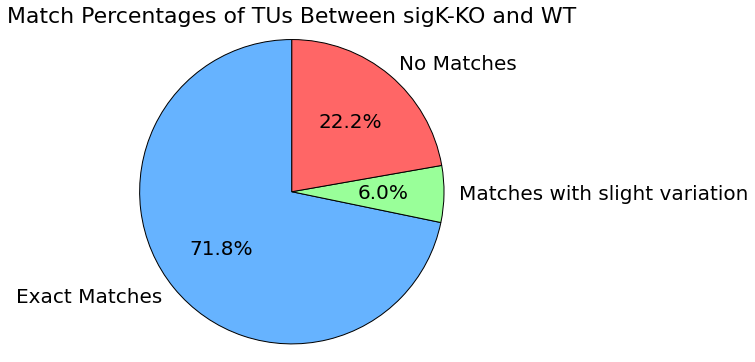

In [10]:
def matching_TUs(data_KO, data_WT):
    # Check how the number of TUs differ between both groups:
    # Check individual TUs, the start and end positions, as in the individual gene (exact matches, matches with slight variation, and no matches)
    tuples_KO = list(zip(data_KO["TU_start"], data_KO["TU_end"], data_KO["Gene_names"]))
    tuples_WT = list(zip(data_WT["TU_start"], data_WT["TU_end"], data_WT["Gene_names"]))
    
    # Extract start and end tuples for comparison
    coords_KO = [(start, end) for start, end, gene in tuples_KO]
    coords_WT = [(start, end) for start, end, gene in tuples_WT]
    
    # Exact matches
    intersection_coords = set(coords_KO) & set(coords_WT)
    intersection_genes = []
    for start, end, genes in tuples_KO:
        if (start, end) in intersection_coords:
            # Split gene names, strip spaces, and add to the list
            intersection_genes.extend([gene.strip() for gene in genes.split(',')])  # Strip leading/trailing spaces

    # Get rid of the exact matches for the subsequent step:
    proc_tuples_KO = [item for item in tuples_KO if (item[0], item[1]) not in intersection_coords]
    proc_tuples_WT = [item for item in tuples_WT if (item[0], item[1]) not in intersection_coords]

    # Perform the for loop for almost matches
    almost_matches = []
    almost_match_genes = []
    for start_KO, end_KO, gene_KO in proc_tuples_KO:
        for start_WT, end_WT, gene_WT in proc_tuples_WT:
            if (abs(start_KO - start_WT) <= 10) and (abs(end_KO - end_WT) <= 10):
                almost_matches.append((start_KO, end_KO))
                # Flatten and strip spaces from gene names
                almost_match_genes.extend([gene.strip() for gene in gene_KO.split(',')])

    # Calculate no matches
    no_matches = len(tuples_KO) - (len(intersection_coords) + len(almost_matches))

    # Pie chart
    labels = ["Exact Matches", "Matches with slight variation", "No Matches"]
    sizes = [len(intersection_coords), len(almost_matches), no_matches]
    colors = ['#66b3ff', '#99ff99', '#ff6666']

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, 
            textprops={'fontsize': 20}, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})
    plt.title('Match Percentages of TUs Between sigK-KO and WT', fontsize=22)
    plt.axis('equal') 
    plt.show()

    # Return gene names for enrichment analysis
    return intersection_genes + almost_match_genes

matching_Tu = matching_TUs(final_TUs_KO, final_TUs_WT)



In [11]:
final_TUs_KO.iloc[266:269]

,TU_name,TU_start,TU_end,TU_strand,TU_len,Gene_names
266,TU_267,701065,701415,+,350,MB0619
267,TU_268,701426,704457,+,3031,"lpqO, MB0621, MB0622, IS1536, MB0623"
268,TU_269,704477,705369,+,892,"vapb28, vapc28, MB0626"


### TUs classification

- Obtain the frecuency of leader/leaderless TUs. In the individual gene classification I have the internal TSSs. Do not need to put the internal TSSs in here, it would be a mess. 
- Compute the 5' UTR length


[1066, 380, 201]


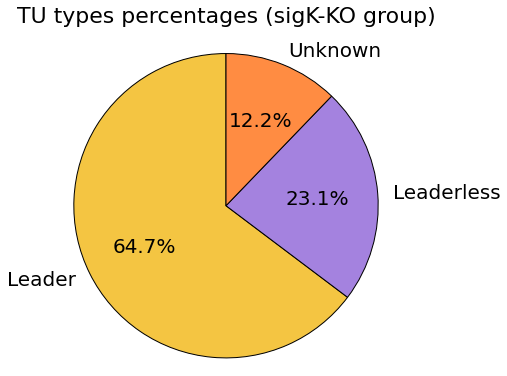

[1082, 383, 196]


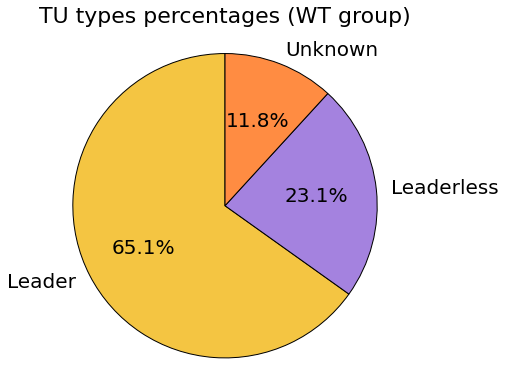

In [12]:
def TUs_class(data, anot_file, no_int_file, group):

    # Loop over the TUs data to select each TU
    for i in range(len(data)):

        # Get the gene names within each TU
        gene_names = data.loc[i, "Gene_names"].split(",")  # Turn it into a list
        first_gene_start = (anot_file["start"][anot_file["gene_name"] == gene_names[0]]).values[0]
        TU_start = data.loc[i, "TU_start"]

        pos_dif = abs(first_gene_start - TU_start)

        # First we need to classify the unknown:
        has_TSS = []
        for gene in gene_names:
            if gene in no_int_file["Gene_name"].values:
                has_TSS.append(True)

        if not has_TSS:
            data.loc[i,"TU_type"] = "Unknown"
            data.loc[i,"5UTR_len"] = "-"

        else:
            if pos_dif < 5:
                data.loc[i,"TU_type"] = "Leaderless"
                data.loc[i,"5UTR_len"] = "-"
        
            elif 5 < pos_dif < 300:
                data.loc[i,"TU_type"] = "Leader"
                data.loc[i,"5UTR_len"] = pos_dif

    # Make the plot
    labels = ["Leader", "Leaderless", "Unknown"]   #change unkown - unclassied
    sizes = [(data["TU_type"] == "Leader").sum(), (data["TU_type"] == "Leaderless").sum(), (data["TU_type"] == "Unknown").sum()]
    colors = ['#f4c542', '#a482df', '#ff8c42']
    print(sizes)
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 20}, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})
    plt.title(f'TU types percentages ({group} group)', fontsize = 22, pad = 20)
    plt.axis('equal') 
    plt.show()

    return data

TUs_class_KO = TUs_class(final_TUs_KO, anot_file, no_int_file_KO, "sigK-KO")
TUs_class_KO.to_excel("Data_outputs/TUs/TUs_class/TUs_class_KO.xlsx")
TUs_class_WT = TUs_class(final_TUs_WT, anot_file, no_int_file_WT, "WT")
TUs_class_WT.to_excel("Data_outputs/TUs/TUs_class/TUs_class_WT.xlsx")

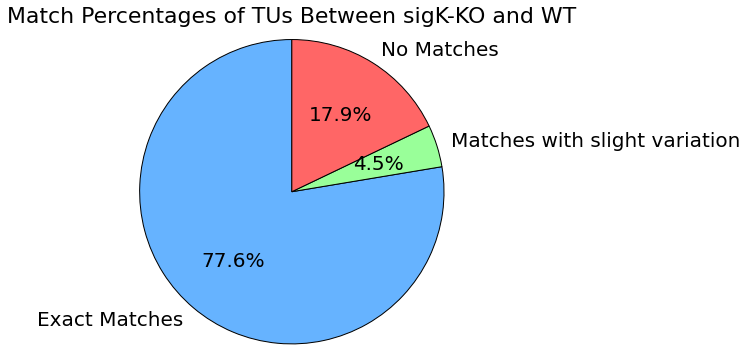

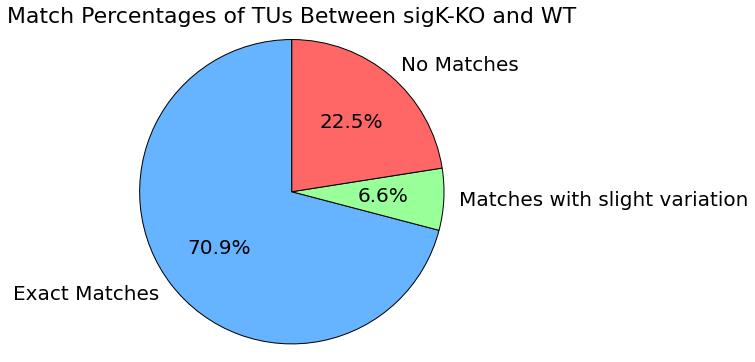

In [13]:
# Check the matching percentages between the leaderless TUs
leaderless_KO = TUs_class_KO[TUs_class_KO["TU_type"] == "Leaderless"]
leaderless_WT = TUs_class_WT[TUs_class_WT["TU_type"] == "Leaderless"]

leaderless_genes = matching_TUs(leaderless_KO, leaderless_WT)

leader_KO = TUs_class_KO[TUs_class_KO["TU_type"] == "Leader"]
leader_WT = TUs_class_WT[TUs_class_WT["TU_type"] == "Leader"]

leader_genes = matching_TUs(leader_KO, leader_WT)

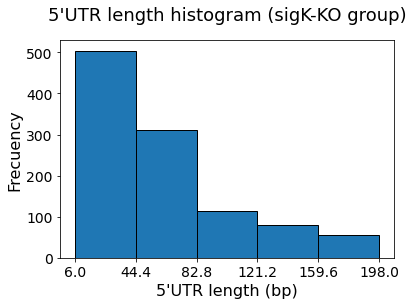

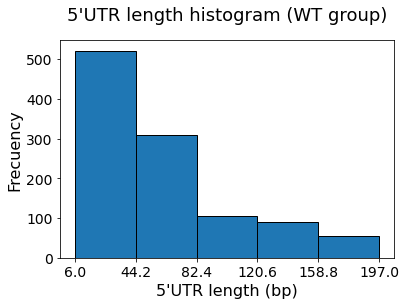

In [14]:
# Code to analyse 5'UTRs:

def UTR_hist(data, TU_type):
    IRs = data["5UTR_len"][data["5UTR_len"] != "-"].tolist()

    # Code for the histogram
    n, bins, patches = plt.hist(IRs, bins=5, edgecolor = "black")
    plt.xlabel("5'UTR length (bp)", fontsize = 16)
    plt.ylabel("Frecuency", fontsize = 16)
    plt.xticks(bins, fontsize=14)
    plt.yticks(fontsize = 14)
    plt.title(f"5'UTR length histogram ({TU_type} group)", fontsize = 18, pad = 20 )
    plt.show()

UTR_hist(TUs_class_KO, "sigK-KO")
UTR_hist(TUs_class_WT, "WT")

### Define the intergenic region:

In [15]:
## CODE FOR THE 3rd STEP and 4th STEP

def int_reg(data, anot_file):

    # Dictionary to store the IR lengths
    ir_dict = {"Tu_name":[], "Gene_comb":[], "IR_len":[]}

    for i in range(len(data)):

        gene_names = data.loc[i, "Gene_names"].split(",")  # Turn it into a list
        if len(gene_names) <= 1:
            ir_dict["Tu_name"].append(data.loc[i, "TU_name"])
            ir_dict["Gene_comb"].append("-")
            ir_dict["IR_len"].append("-")

        else:
            for j in range(len(gene_names)-1):
                first_gene = gene_names[j].strip()
                second_gene = gene_names[j+1].strip()

                first_gene_end = anot_file["end"][anot_file["gene_name"] == first_gene].values[0]
                second_gene_sta = anot_file["start"][anot_file["gene_name"] == second_gene].values[0]
                IR_diff = second_gene_sta - first_gene_end

                ir_dict["Tu_name"].append(data.loc[i, "TU_name"])
                ir_dict["Gene_comb"].append(f"{gene_names[j]}-{gene_names[j+1]}")
                ir_dict["IR_len"].append(IR_diff)

    return pd.DataFrame(ir_dict)

IR_KO = int_reg(final_TUs_KO, anot_file)
IR_KO.to_excel("Data_outputs/TUs/IRs_len/IRs_KO.xlsx")
IR_WT = int_reg(final_TUs_WT, anot_file)
IR_WT.to_excel("Data_outputs/TUs/IRs_len/IRs_WT.xlsx")


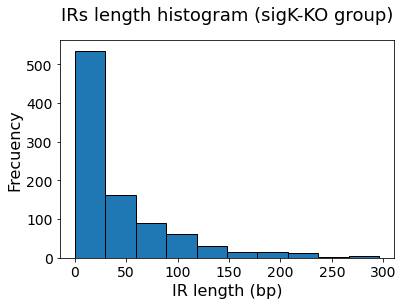

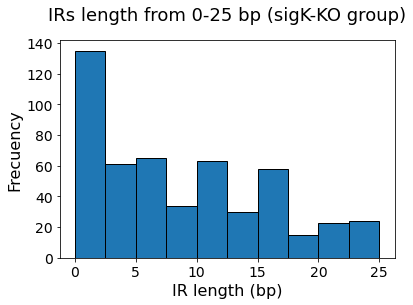

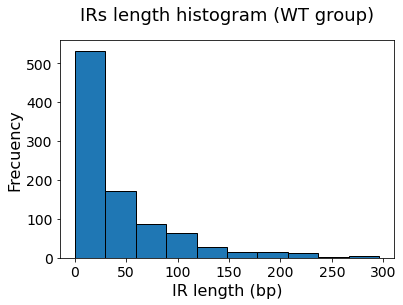

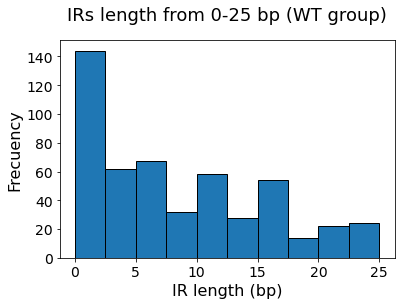

In [16]:
# Histogram to analyse the IRs:
def IR_hist(data, TU_type):
    
    # Filter out TUs that only have a gene
    data = data[data["IR_len"] != "-"]

    # Filter out negative Ir_len, which means that genes are overlapping
    data = data[data["IR_len"] >= 0]

    # Filter out Ir lengths higher than 300 ()
    data = data[data["IR_len"] <= 300]

    IRs = data["IR_len"].tolist()

    # Code for the histogram
    plt.hist(IRs, edgecolor = "black")
    plt.xlabel("IR length (bp)", fontsize = 16)
    plt.ylabel("Frecuency", fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)   
    plt.title(f"IRs length histogram ({TU_type} group)", fontsize = 18, pad = 20)
    plt.show()

    data2 = data[data["IR_len"] <= 25]
    IRs2 = data2["IR_len"].tolist()
    # Code for the histogram
    plt.hist(IRs2, edgecolor = "black")
    plt.xlabel("IR length (bp)", fontsize = 16)
    plt.ylabel("Frecuency", fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)   
    plt.title(f"IRs length from 0-25 bp ({TU_type} group)", fontsize = 18, pad = 20)
    plt.show()
    
IR_hist(IR_KO, "sigK-KO")
IR_hist(IR_WT, "WT")

### Categories of Leaderless TUs types

                                  category  leaderless_percentage  \
5  intermediate metabolism and respiration              26.534296   
3           conserved hypothetical protein              26.353791   
0             cell wall and cell processes              20.036101   
6                         lipid metabolism               8.844765   
7     virulence, detoxification,adaptation               8.122744   
1                     information pathways               5.415162   
2                      regulatory proteins               4.151625   
4                insertion seqs and phages               0.361011   
8                                   PE/PPE               0.180505   

   leader_percentage  
5          22.176871  
3          24.761905  
0          21.224490  
6           6.870748  
7           5.170068  
1           6.870748  
2           5.102041  
4           2.653061  
8           5.170068  


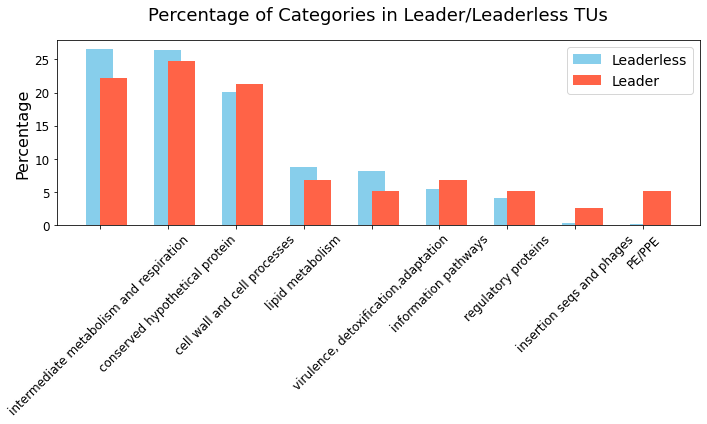

In [17]:

def gene_name_conversion(list_of_genes, raw_anot):
    """List of genes in the wrong format and converts it to the M. tuberculosis locus tag"""

    # Add the gene name column to raw_anot
    raw_anot["gene_name"] = raw_anot["attributes"].str.extract(r'gene=([A-Za-z0-9_]+)')

    # Convert the leaderless genes to a compatible format with the categories dataset
    new_list_of_genes = []
    for gene in list_of_genes:
        if gene.startswith("MB"):
            new_gene = gene.replace("B", "b").strip() # make this letter to be capital
            # Check if the locus tag ends with a letter (not a number or other character)
            if new_gene[-1].isalpha(): 
                new_gene = new_gene[:-1] + new_gene[-1].upper()  # Capitalize the last letter
            new_list_of_genes.append(new_gene)

        else:
            atrib_line = raw_anot["attributes"][raw_anot["gene_name"] == gene.strip()]
            locus_tag = atrib_line.str.extract(r'locus_tag=[A-Za-z0-9_]+_(MB\d+[a-zA-Z]?)')[0]

            if not locus_tag.isna().all():  # Ensure locus_tag is not empty
                locus_tag = locus_tag.values[0].replace("B", "b").strip()
                # Check if the locus tag ends with a letter (not a number or other character)
                if locus_tag[-1].isalpha(): 
                    locus_tag = locus_tag[:-1] + locus_tag[-1].upper()  # Capitalize the last letter
                new_list_of_genes.append(locus_tag)
            else:
                new_list_of_genes.append("No_translation")

    return new_list_of_genes

def categorize_leading_genes(genes, annotation_file, gene_category):

    # Convert gene names based on the annotation file
    converted_genes = gene_name_conversion(genes, annotation_file)
    categorized_genes_df = pd.DataFrame({"Mb_tag": genes, "Mb_form": converted_genes})

    # Remove untranslated genes
    categorized_genes_df = categorized_genes_df[categorized_genes_df["Mb_form"] != "No_translation"]

    # Create dictionaries for mapping Mb_tag to Rv_tag and categories
    mbovis_to_rv_dict = dict(zip(mbovis_cat['Mb_tag'], mbovis_cat['Rv_tag']))
    mbovis_to_category_dict = dict(zip(mbovis_cat['Mb_tag'], mbovis_cat['category']))

    # Map Mb_form to Rv_tag and category
    categorized_genes_df["Rv_tag"] = categorized_genes_df["Mb_form"].map(mbovis_to_rv_dict)
    categorized_genes_df["category"] = categorized_genes_df["Mb_form"].map(mbovis_to_category_dict)

    # Output the results to an Excel file
    categorized_genes_df.to_excel(f"Data_outputs/TUs/TUs_class/{gene_category}_genes.xlsx", index=False)

    return categorized_genes_df

cat_leaderless_genes = categorize_leading_genes(leaderless_genes, raw_anot_file, "Leaderless")
cat_leader_genes = categorize_leading_genes(leader_genes, raw_anot_file, "Leader")


# Make bar plot
count_categories_leaderless = cat_leaderless_genes["category"].value_counts()
count_categories_leader = cat_leader_genes["category"].value_counts()

# Calculate percentages for both leaderless and leader categories
percentages_leaderless = (count_categories_leaderless / count_categories_leaderless.sum()) * 100
# print(percentages_leaderless)
percentages_leader = (count_categories_leader / count_categories_leader.sum()) * 100
# print(percentages_leader)

percentages_df = pd.DataFrame({"category": pd.Series(mbovis_cat["category"].unique()).dropna()})


leaderless_percentages = []
leader_percentages = []

for cat in percentages_df["category"].tolist():
    # Get percentage for leaderless
    if cat in percentages_leaderless.index:
        leaderless_percentages.append(percentages_leaderless[cat])

    # Get percentage for leader
    if cat in percentages_leader.index:
        leader_percentages.append(percentages_leader[cat])

# Add the calculated percentages as columns in the DataFrame
percentages_df["leaderless_percentage"] = leaderless_percentages
percentages_df["leader_percentage"] = leader_percentages

# Sort the DataFrame by leaderless percentages in descending order
percentages_df = percentages_df.sort_values(by="leaderless_percentage", ascending=False)

print(percentages_df)

# Plot both Leaderless and Leader categories in a single bar plot
plt.figure(figsize=(10, 6))

# Plot Leaderless percentages
plt.bar(percentages_df["category"], percentages_df["leaderless_percentage"], 
        color="skyblue", width=0.4, label="Leaderless", align="center")

# Plot Leader percentages next to Leaderless
plt.bar(percentages_df["category"], percentages_df["leader_percentage"], 
        color="tomato", width=0.4, label="Leader", align="edge")

# Title and labels
plt.title(f"Percentage of Categories in Leader/Leaderless TUs", fontsize=18, pad=20)
plt.ylabel("Percentage", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=14, title_fontsize=12)

# Adjust layout to ensure labels fit
plt.tight_layout()

# Show plot
plt.show()


<ipython-input-18-9e945b62778a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leader_TSS['log_TSS_depth'] = np.log10(leader_TSS['TSS_depth'] + 1)  # Adding 1 to avoid log(0)
<ipython-input-18-9e945b62778a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leaderless_TSS['log_TSS_depth'] = np.log10(leaderless_TSS['TSS_depth'] + 1)
<ipython-input-18-9e945b62778a>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

sigK-KO - Leader:
  Median: 2.02
  IQR: 1.08 (Q1: 1.53, Q3: 2.61)

sigK-KO - Leaderless:
  Median: 2.23
  IQR: 1.10 (Q1: 1.74, Q3: 2.84)



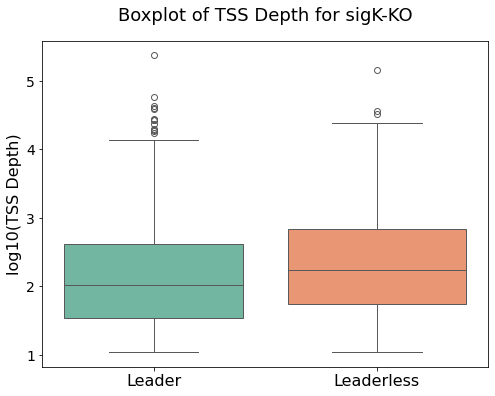

<ipython-input-18-9e945b62778a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leader_TSS['log_TSS_depth'] = np.log10(leader_TSS['TSS_depth'] + 1)  # Adding 1 to avoid log(0)
<ipython-input-18-9e945b62778a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leaderless_TSS['log_TSS_depth'] = np.log10(leaderless_TSS['TSS_depth'] + 1)
<ipython-input-18-9e945b62778a>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

WT - Leader:
  Median: 2.02
  IQR: 1.13 (Q1: 1.52, Q3: 2.65)

WT - Leaderless:
  Median: 2.27
  IQR: 1.26 (Q1: 1.67, Q3: 2.93)



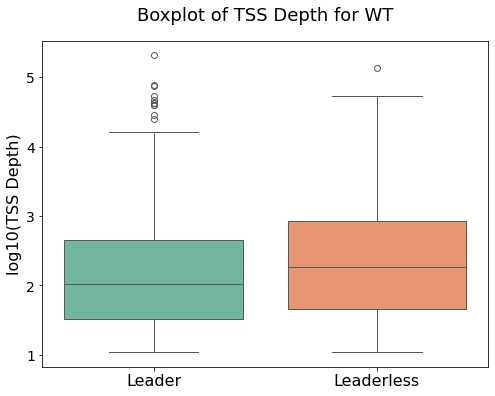

In [18]:
def box_plot(TSS_data, group):
    # Get the leader/leaderless TSSs
    leader_TSS = TSS_data[TSS_data["TSS_type"] == "Leader"]
    leaderless_TSS = TSS_data[TSS_data["TSS_type"] == "Leaderless"]
    
    # Apply log10 transformation to TSS_depth, adding a small constant to avoid log(0)
    leader_TSS['log_TSS_depth'] = np.log10(leader_TSS['TSS_depth'] + 1)  # Adding 1 to avoid log(0)
    leaderless_TSS['log_TSS_depth'] = np.log10(leaderless_TSS['TSS_depth'] + 1)

    # Compute median and IQR for leader and leaderless TSS
    for name, subset in [('Leader', leader_TSS), ('Leaderless', leaderless_TSS)]:
        median = subset['log_TSS_depth'].median()
        q1 = subset['log_TSS_depth'].quantile(0.25)
        q3 = subset['log_TSS_depth'].quantile(0.75)
        iqr = q3 - q1
        print(f"{group} - {name}:")
        print(f"  Median: {median:.2f}")
        print(f"  IQR: {iqr:.2f} (Q1: {q1:.2f}, Q3: {q3:.2f})")
        print()
    
    # Combine the two TSS types for plotting
    combined_data = pd.concat([leader_TSS[['log_TSS_depth', 'TSS_type']], leaderless_TSS[['log_TSS_depth', 'TSS_type']]])
    combined_data['Group'] = group  # Add the group information (sigK-KO or WT)

    # Create the box plot using seaborn
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='TSS_type', y='log_TSS_depth', data=combined_data, palette="Set2")

    # Title and labels
    plt.title(f'Boxplot of TSS Depth for {group}', fontsize=18, pad = 20)
    plt.xlabel('', fontsize=16)
    plt.ylabel('log10(TSS Depth)', fontsize=16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 14)
    
    # Show plot
    plt.show()



box_plot(final_TSS_KO, "sigK-KO")
box_plot(final_TSS_WT, "WT")



### Focus on sigK and genes regulated by sigK.
- In the WT file we have the following TSSs: pos = 533947	depth = 11	type = Leader gene = rska (more information about the Tu can be found in the excel file)
- Final TU: rska, sigK, MB0454c, ufaA1, MB0456c, MB0457c, mmpL4, mmpS4
- In the KO file there's any TSS before rska, which makes sense

- Other genes regulated by sigK: 
    - WT: Leader TU with the genes: mpt83, dipZ / Leader TU with the genes: mpt70, MB2901
    - KO: since the proteins are not expressed, there's no TSS before mpt83 and mpt70 and hence the whole TU is the same as the preliminary but with leader TSS belonging to vapb43

In [19]:
# Define sigK preliminary TU
sigK_prel_TU = [
    ["CDS", 534110, 534808, "-", "rska"],
    ["CDS", 534852, 535415, "-", "sigK"],
    ["CDS", 535464, 536234, "-", "MB0454c"],
    ["CDS", 536243, 537526, "-", "ufaA1"],
    ["CDS", 537523, 538188, "-", "MB0456c"],
    ["CDS", 538248, 539567, "-", "MB0457c"],
    ["CDS", 539607, 542510, "-", "mmpL4"],
    ["CDS", 542507, 542929, "-", "mmpS4"],
]
sigK_prel_TU = pd.DataFrame(sigK_prel_TU, columns=["Type", "Start", "End", "Strand", "Gene"])

# Define preliminary of other genes. 
other_genes = [
    ["CDS", 3144066, 3144323, "+", "vapb43"],
    ["CDS", 3144310, 3144753, "+", "vapc43"],
    ["CDS", 3144833, 3145495, "+", "mpt83"],
    ["CDS", 3145775, 3147862, "+", "dipZ"],
    ["CDS", 3147958, 3148539, "+", "mpt70"],
    ["CDS", 3148591, 3148905, "+", "MB2901"],
]

# Create a DataFrame
df = pd.DataFrame(other_genes, columns=["Type", "Start", "End", "Strand", "Gene"])



In [20]:
sigK_prel_TU

,Type,Start,End,Strand,Gene
0,CDS,534110,534808,-,rska
1,CDS,534852,535415,-,sigK
2,CDS,535464,536234,-,MB0454c
3,CDS,536243,537526,-,ufaA1
4,CDS,537523,538188,-,MB0456c
5,CDS,538248,539567,-,MB0457c
6,CDS,539607,542510,-,mmpL4
7,CDS,542507,542929,-,mmpS4


### Internal TSS

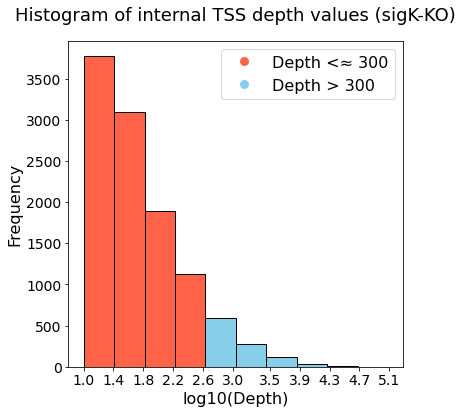

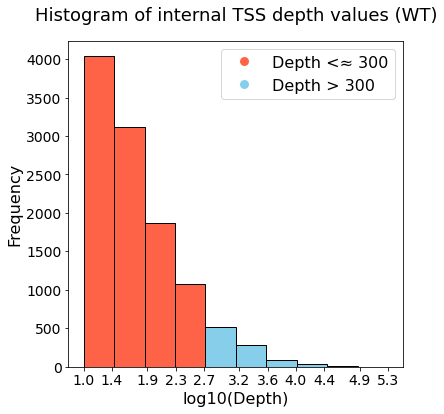

In [21]:
# Make a histogram of the internal genes

def int_TSS_hist(data, group):
    int_TSS = data[data["TSS_type"] == "Internal"]
    transf_data = np.log10(int_TSS["TSS_depth"])

    # Define colors based on depth values
    colors = ['tomato'] * 4 + ["skyblue"] * 6
 
    plt.figure(figsize = (6,6))
    counts, bin_edges, bar_object = plt.hist(transf_data, bins = 10, edgecolor = "black")
    # Add colors 
    for i in range(len(bar_object)):
        bar_object[i].set_facecolor(colors[i])

    # Add manual legend
    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=10, label="Depth <≈ 300")
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=10, label="Depth > 300")
    plt.legend(handles=[red_patch, blue_patch], fontsize = 16)
        
    plt.xlabel("log10(Depth)", fontsize = 16)
    plt.ylabel("Frequency", fontsize = 16)
    plt.xticks(np.round(bin_edges,1), fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.title(f"Histogram of internal TSS depth values ({group})", fontsize = 18, pad = 20)
    plt.show()

    pass

int_TSS_hist(final_TSS_KO, "sigK-KO")
int_TSS_hist(final_TSS_WT, "WT")

cdist ->  calculates the pairwise distances between all TSS and TTS positions, which is faster than checking each pair manually

In [24]:
# Get the internal TSS. Make the code to get those TTS that are internal, and then apply the following functions to get the pairs of only the TSS that are very large

def internal_fragments(TSS_data, TTS_data, raw_anot):

    # Get the internal TSS and TTS and filter out those with depth < 300
    internal_data_TSS = TSS_data[TSS_data["TSS_type"] == "Internal"]
    internal_data_TSS = internal_data_TSS[internal_data_TSS["TSS_depth"] >= 300]

    # Get the positions of the internal TSS and TTS
    pos_int_TSS = internal_data_TSS["TSS_position"]
    pos_int_TTS = TTS_data["TTS_position"]

    # Get the positions of the internal TSS and TTS
    pos_int_TSS = np.array(internal_data_TSS["TSS_position"])
    pos_int_TTS = np.array(TTS_data["TTS_position"])

    # Compute the distance matrix using broadcasting
    dist_matrix = pos_int_TTS.reshape(1, -1) - pos_int_TSS.reshape(-1, 1)

    # Keep only positive distances (set negative distances to infinity)
    dist_matrix = dist_matrix.astype(float) # Convert dist_matrix to float type to allow np.inf assignment
    dist_matrix[dist_matrix < 0] = np.inf

    # Find the index of the closest TTS for each TSS
    closest_TTS_indices = np.argmin(dist_matrix, axis=1)  #Returns the index of the min distance across the rows

    # Now, you can pair each TSS with its closest TTS
    pairs = [(pos_int_TSS[i], pos_int_TTS[closest_TTS_indices[i]]) for i in range(len(pos_int_TSS))]

    # Make a data frame with start-end positions
    start_l = []  
    end_l = []    
    len_ = []     
    TSS_genes = []  
    TTS_genes = []  

    for start, end in pairs:
        start_l.append(start)
        TSS_gene = TSS_data["Gene_name"][TSS_data["TSS_position"] == start].values[0]
        TSS_genes.append(TSS_gene)
        
        end_l.append(end)
        TTS_gene = TTS_data["Gene_name"][TTS_data["TTS_position"] == end].values[0]
        TTS_genes.append(TTS_gene)
        
        # Compute the length
        len_.append(end - start)

    int_frag_df = pd.DataFrame({"Start_frag":start_l, "End_frag":end_l, "Frag_len":len_, "TSS_gene":TSS_genes, "TTS_gene":TTS_genes})

    # Filter out fragment that do not belong to the same gene
    int_frag_df = int_frag_df[int_frag_df["TSS_gene"] == int_frag_df["TTS_gene"]]

    print(f"There are {(int_frag_df['Frag_len'] > 100).sum()} larger than 100")

    # Get the genes which contain fragments
    genes_with_frag = int_frag_df["TTS_gene"].unique()
    

    return int_frag_df, genes_with_frag

interal_frag_KO, genes_with_frag_KO = internal_fragments(final_TSS_KO, final_TTS_KO, raw_anot_file)
interal_frag_KO.to_excel("Data_outputs/TUs/Internal_frag/interal_frag_KO.xlsx")
interal_frag_WT, genes_with_frag_WT = internal_fragments(final_TSS_WT, final_TTS_WT, raw_anot_file)
interal_frag_WT.to_excel("Data_outputs/TUs/Internal_frag/interal_frag_WT.xlsx")

There are 12 larger than 100
There are 11 larger than 100


In [25]:
interal_frag_WT["Frag_len"].mean()

48.34945788156797

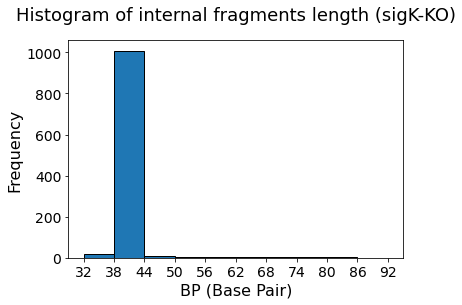

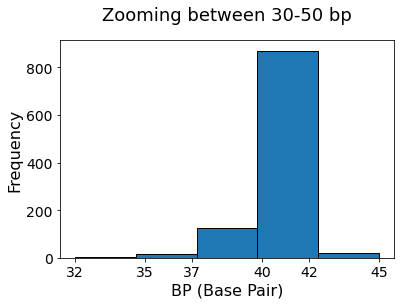

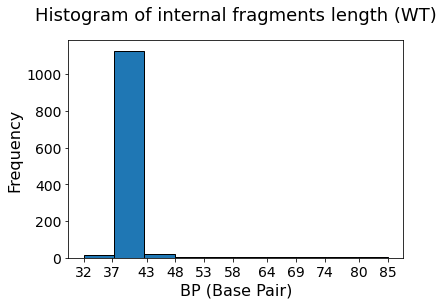

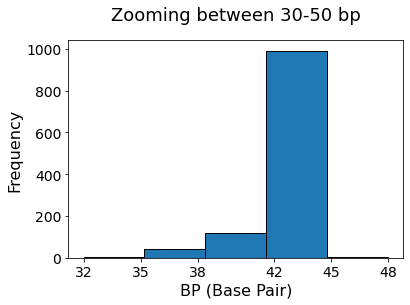

In [26]:
def hist_inter_frag(data, group):

    data_1 = data["Frag_len"][data["Frag_len"] < 100]

    counts, bin_edges, _ = plt.hist(data_1, edgecolor = "black")
    plt.xlabel("BP (Base Pair)", fontsize = 16)
    plt.ylabel("Frequency", fontsize = 16)
    plt.xticks(np.round(bin_edges, 0), fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.title(f"Histogram of internal fragments length ({group})", fontsize = 18, pad = 20)
    plt.show()

    data_2 = data["Frag_len"][(data["Frag_len"] > 30) & (data["Frag_len"] < 50)]

    counts, bin_edges, _ = plt.hist(data_2, bins = 5, edgecolor = "black")
    plt.xlabel("BP (Base Pair)", fontsize = 16)
    plt.ylabel("Frequency", fontsize = 16)
    plt.xticks(np.round(bin_edges, 0), fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.title(f"Zooming between 30-50 bp", fontsize = 18, pad = 20)
    plt.show()

    pass

hist_inter_frag(interal_frag_KO, "sigK-KO")
hist_inter_frag(interal_frag_WT, "WT")

KO group has 1075 internal fragments
WT group has 1199 internal fragments


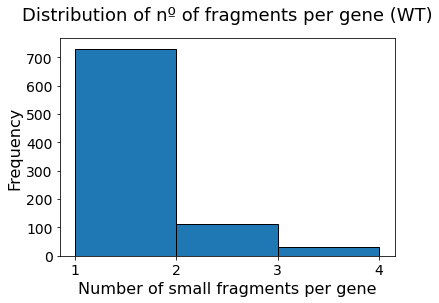

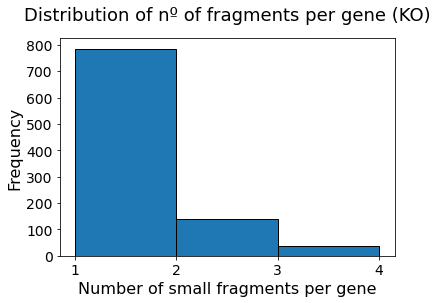

In [27]:
print(f"KO group has {len(interal_frag_KO)} internal fragments")
print(f"WT group has {len(interal_frag_WT)} internal fragments")

def frag_hist(data, group):
    unique_gene_list = data["TSS_gene"].unique()
    
    list_n_genes = []
    for gene in unique_gene_list:
        n_frag_per_gene = len(data[data["TSS_gene"] == gene])

        if n_frag_per_gene >= 5:
            continue

        list_n_genes.append(n_frag_per_gene)

    counts, bin_edges, _ = plt.hist(list_n_genes, bins = 3, edgecolor = "black")
    plt.xlabel("Number of small fragments per gene", fontsize = 16)
    plt.ylabel("Frequency", fontsize = 16)
    plt.xticks(np.round(bin_edges, 0), fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.title(f"Distribution of nº of fragments per gene ({group})", fontsize = 18, pad = 18)
    plt.show()


frag_hist(interal_frag_KO, "WT")
frag_hist(interal_frag_WT, "KO")

In [28]:
interal_frag_KO

,Start_frag,End_frag,Frag_len,TSS_gene,TTS_gene
0,389,431,42,dnaA,dnaA
1,1221,1263,42,dnaA,dnaA
2,2259,2301,42,dnaN,dnaN
3,3012,3080,68,dnaN,dnaN
4,3401,3440,39,recF,recF
...,...,...,...,...,...
1348,4336720,4336762,42,MB3940,MB3940
1349,4338815,4338857,42,sigMa,sigMa
1350,4343873,4343915,42,parB,parB
1351,4346389,4346428,39,gid,gid
